# Comparing and training RandomForest

In [23]:
import pandas as pd
import numpy as np
import pickle


from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.neural_network import MLPRegressor
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from math import sqrt

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from sklearn.metrics import explained_variance_score

import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

In [1]:
import keras

Using Theano backend.
WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.utils import to_categorical

## Working dir

In [2]:
work_Folder1 = r'C:\Users\perin\OneDrive\Desktop\Kristian\python\Data analysis\Aorta Data\ScanRescan0158\S1'
work_Folder2 = r'C:\Users\perin\OneDrive\Desktop\Kristian\python\Data analysis\Aorta Data\ScanRescan0158\S2'
work_Folder3 = r'C:\Users\perin\OneDrive\Desktop\Kristian\python\Data analysis\Aorta Data\ScanRescan0158\S3'
work_Folder4 = r'C:\Users\perin\OneDrive\Desktop\Kristian\python\Data analysis\Aorta Data\ScanRescan0158\S4'

model_Folder = r'C:\Users\perin\OneDrive\Desktop\Kristian\python\Data analysis\Aorta Data\ScanRescan0158\Model param'

S_data = 'Scan2_finalOutput.csv'
model_file_name = 'RFM_Stand_input.sav'

S1_data_path = work_Folder1 + "\\" + S_data
S2_data_path = work_Folder2 + "\\" + S_data
S3_data_path = work_Folder3 + "\\" + S_data
S4_data_path = work_Folder4 + "\\" + S_data

model_path = model_Folder + "\\" + model_file_name


## importing data

In [3]:
df_S1 = pd.read_csv(S1_data_path)
df_S2 = pd.read_csv(S2_data_path)
df_S3 = pd.read_csv(S3_data_path)
df_S4 = pd.read_csv(S4_data_path)

## Merging S1, S2 & S3

## Defining features

In [5]:
df_S1_S2 = df_S1.append(df_S2)
df_S123 = df_S1_S2.append(df_S3)

In [4]:
df_S1.columns

Index(['Unnamed: 0', 'X_SP', 'Y_SP', 'Z_SP', 'velocity_magnitude',
       'x_velocity', 'y_velocity', 'z_velocity', 'wall_shear', 'x_wall_shear',
       'y_wall_shear', 'z_wall_shear', 'pressure', 'velocity0', 'velocity1',
       'velocity2', 'GroupIds', 'AngularMetric', 'AbscissaMetric',
       'Unnamed: 0.1', 'centerline_point_index', 'min_distance',
       'point_vector', 'X_CLP', 'Y_CLP', 'Z_CLP',
       'MaximumInscribedSphereRadius', 'Abscissas',
       'ParallelTransportNormals0', 'ParallelTransportNormals1',
       'ParallelTransportNormals2', 'Curvature', 'Torsion', 'FrenetTangent0',
       'FrenetTangent1', 'FrenetTangent2', 'FrenetNormal0', 'FrenetNormal1',
       'FrenetNormal2', 'FrenetBinormal0', 'FrenetBinormal1',
       'FrenetBinormal2', 'centerline_length', 'bumpy', 'Area', 'index_CL'],
      dtype='object')

### All features

In [7]:
#X = df_S123[['Area','bumpy','Curvature','Torsion','AngularMetric','centerline_length']]
#y = df_S123['wall_shear']

X_S1 = df_S1[['Area','bumpy','Curvature','Torsion','AngularMetric','AbscissaMetric']]
y_S1 = df_S1['wall_shear']

X_S4 = df_S4[['Area','bumpy','Curvature','Torsion','AngularMetric','AbscissaMetric']]
y_S4 = df_S4['wall_shear']

## (optional) normalization step

In [84]:
#transformer = StandardScaler().fit(X)
#X_norm = transformer.transform(X)
#df_xnorm = pd.DataFrame(X_norm)

transformer = StandardScaler().fit(X_S1)
X_norm = transformer.transform(X_S1)
df_S1_norm = pd.DataFrame(X_norm)

transformer = StandardScaler().fit(X_S4)
X_norm = transformer.transform(X_S4)
df_S4_xnorm = pd.DataFrame(X_norm)

# [['Area','bumpy','Curvature','Torsion','AngularMetric','centerline_length']]
df_S1_norm[6] = df_S1_norm[0] * df_S1_norm[2] * df_S1_norm[3] * df_S1_norm[5]**2

df_S1_norm = df_S1_norm.drop(columns =[0, 2,3,5])
df_S1_norm.head()


,1,4,6
0,0.838210,0.840328,0.046235
1,1.081651,0.819602,0.046235
2,-0.660962,1.010253,0.046235
3,-0.464935,0.981285,0.046235
4,2.334521,-0.746555,0.046235


In [ ]:
df_S1_norm

## Splitting test and training data

In [85]:
x_train, x_test, y_train, y_test = train_test_split(df_S1_norm, y_S1, test_size=0.30, random_state=0)

In [86]:
x_test.describe()

,1,4,6
count,31632.000000,31632.000000,31632.000000
mean,0.001944,-0.002763,-0.109785
std,0.999921,0.999843,3.221038
min,-1.876897,-1.862582,-51.974135
25%,-0.768409,-0.837751,-0.013535
50%,-0.297399,0.050730,0.000090
75%,0.467782,0.835729,0.015998
max,5.885045,1.748758,53.342847


## Training parameter optimization MLP_regressor

The paramters have been obtained from another file and used here

In [87]:
parameter_space = {
    'hidden_layer_sizes': [(3,50,1), (3,75,1), (3,100,1)],
    'activation': ['tanh', 'relu'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive'],
}

In [ ]:
from sklearn.model_selection import GridSearchCV

clf = GridSearchCV(mlp, parameter_space, n_jobs=4, cv=3)
clf.fit(x_train, y_train)

In [ ]:
 #Best paramete set
print('Best parameters found:\n', clf.best_params_)

# All results
means = clf.cv_results_['mean_test_score']
stds = clf.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, clf.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

In [77]:
mlp = MLPRegressor(activation= 'tanh', alpha= 0.0001,max_iter=10000, hidden_layer_sizes= (6, 75,4, 1), learning_rate='adaptive', solver='adam')
mlp.fit(x_train, y_train)

MLPRegressor(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(6, 75, 4, 1), learning_rate='adaptive',
       learning_rate_init=0.001, max_iter=10000, momentum=0.9,
       n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
       random_state=None, shuffle=True, solver='adam', tol=0.0001,
       validation_fraction=0.1, verbose=False, warm_start=False)

## Scoring on test data (same segmentation)

In [78]:
# Use the forest's predict method on the test data
predictions = mlp.predict(x_test)

print('Metrics for Random Forest on Expanded Data')

# Calculate the absolute errors
errors = abs(predictions - y_test)# Print out the mean absolute error (mae)
#errors_SVR = abs(predictions_SVR - y_test)# Print out the mean absolute error (mae)

print('Mean Absolute Error_RM:', round(np.mean(errors), 2))

rms = sqrt(mean_squared_error(y_test, predictions))

print('rms:', round(rms, 2), '.')

R2 = r2_score(y_test, predictions)
print('R2:', round(R2, 2))

Metrics for Random Forest on Expanded Data
Mean Absolute Error_RM: 1.99
rms: 2.83 .
R2: 0.8


In [26]:
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

## Scoring on new geometries

In [79]:
# load the model from disk
#model = pickle.load(open(model_path, 'rb'))
y_pred_S4 = mlp.predict(df_S4_xnorm)
y_pred_S1 = mlp.predict(df_S1_xnorm)

errors_S4 = abs(y_pred_S4 - y_S4)
errors_S1 = abs(y_pred_S1 - y_S1)

print('Mean Absolute Error_RM_S4:', round(np.mean(errors_S4), 2))
print('Mean Absolute Error_RM_S4:', round(np.mean(errors_S1), 2))

rms = sqrt(mean_squared_error(y_S4, y_pred_S4))

print('rms:', round(rms, 2), '.')

R2 = r2_score(y_S4, y_pred_S4)
print('R2:', round(R2, 2))

Mean Absolute Error_RM_S4: 4.62
Mean Absolute Error_RM_S4: 1.99
rms: 7.43 .
R2: -0.39


## export predictions

In [139]:
df_S1_pred = df_S1.merge(pd.DataFrame({'wall_shear_pred':y_pred_S1}),left_index=True,right_index=True)
df_S1_pred.to_csv(work_Folder1 + "\\" + 'S1_pred_feature_sel.csv')

df_S2_pred = df_S2.merge(pd.DataFrame({'wall_shear_pred':y_pred_S2}),left_index=True,right_index=True)
df_S2_pred.to_csv(work_Folder2 + "\\" + 'S2_pred_feature_sel.csv')

df_S3_pred = df_S3.merge(pd.DataFrame({'wall_shear_pred':y_pred_S3}),left_index=True,right_index=True)
df_S3_pred.to_csv(work_Folder3 + "\\" + 'S3_pred_feature_sel.csv')

df_S4_pred = df_S4.merge(pd.DataFrame({'wall_shear_pred':y_pred_S4}),left_index=True,right_index=True)
df_S4_pred.to_csv(work_Folder4 + "\\" + 'S4_pred_feature_sel.csv')

## preliminary comparison of results

In [88]:
df_results = pd.DataFrame([y_pred_S1,y_S1,
                           y_pred_S2,y_S2,
                           y_pred_S3,y_S3,
                           y_pred_S4,y_S4])
df_results = df_results.T

## Visualization of results

<IPython.core.display.Javascript object>


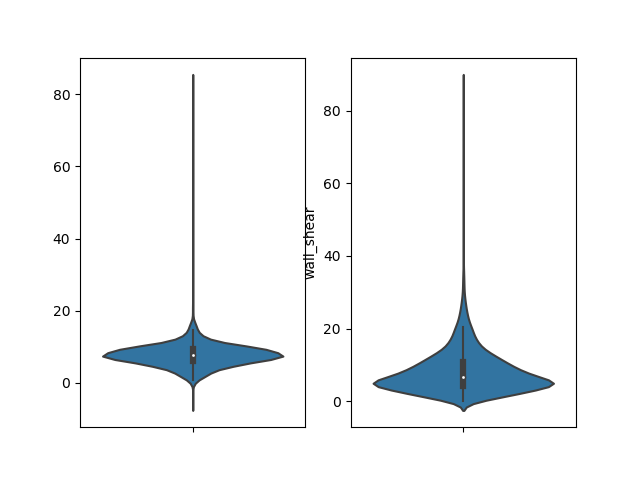

In [13]:
%matplotlib notebook
plt.subplot(121)
ax = sns.violinplot(y=y_pred_S1,bw=.2)
plt.subplot(122)
ax = sns.violinplot(y=y_S1, bw=.2)
plt.show()